/tmp/ipykernel_3683336/851833906.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for bars, hatch, legend_handle in zip(ax.containers, ['//', '', '', '', '', ], ax.legend_.legendHandles):


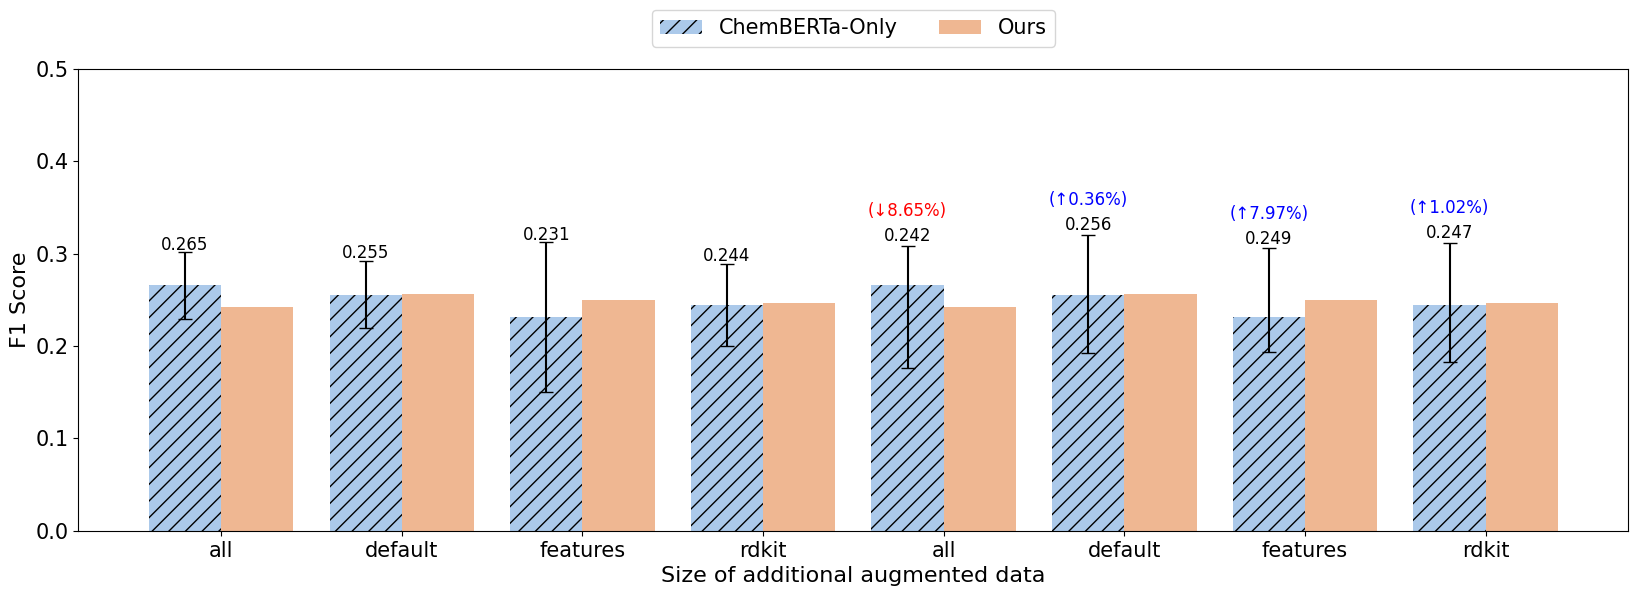

In [29]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd


path = f"./plot_data/baseline/"
files = f"result_metrics"
y_aim = [0.0, 0.5]
# error_aim = [3.0, 1.5, 2.5]
error_aim = 3.0

order_list = ["ChemBERTa-Only", "Ours"]

df_score = pd.read_csv(path + f"{files}.csv")
df_plotdata = df_score

# Change the color palette
sns.reset_defaults()
sns.set_palette('pastel')  # You can choose other palettes like 'deep', 'muted', 'bright', 'pastel', 'dark', 'colorblind'

df_groupdata = df_plotdata.groupby(["framework","feature_type", "model_type"]).agg(rm2_mean = ("test_rm2", "mean"), rm2_std = ("test_rm2", "std")).reset_index()
df_groupdata['framework'] = df_groupdata['framework'].astype('category')
df_groupdata['framework'] = df_groupdata['framework'].cat.set_categories(order_list)
df_groupdata = df_groupdata.sort_values(['framework', 'feature_type'])

# models = df_groupdata['feature_type'].unique()
aug_size = ["default", "features", "rdkit", "all"]
plt.figure(figsize=(20, 6))

filtered_df = df_groupdata[df_groupdata['feature_type'].isin(aug_size)]
ax = sns.barplot(x="feature_type", y="rm2_mean", hue="framework", capsize=.2, data=df_groupdata, order=list(df_groupdata["feature_type"]))

# for aug_len in aug_size:
    # df_sampled = filtered_df[df_groupdata['addition_size'] == aug_len]
for bars, hatch, legend_handle in zip(ax.containers, ['//', '', '', '', '', ], ax.legend_.legendHandles):
    for bar in bars:
        bar.set_hatch(hatch)
    # update the existing legend
    legend_handle.set_hatch(hatch + hatch)
        
x_positions = [p.get_x() + p.get_width() / 2. for p in ax.patches][:len(df_groupdata['framework'])]
zero_index = x_positions.index(0.0) if 0.0 in x_positions else len(x_positions)
x_positions = x_positions[:zero_index] 

y_means = filtered_df["rm2_mean"]
y_errors = filtered_df["rm2_std"]

ax.errorbar(x_positions, y_means, yerr=y_errors, fmt='none', capsize=5, color='black', zorder=5)
# barplot 위에 평균 값 annotation
for plot_idx, (p, y_mean, y_error) in enumerate(zip(ax.patches, y_means, y_errors)):
    if plot_idx in range(len(aug_size)):
        ax.annotate(f'{y_mean:.3f}', (p.get_x() + p.get_width() / 2., y_mean + y_error + 0.001),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)
        
    else:
        # Calculate the percentage difference from 'w/o CL'
        baseline_value = float(filtered_df[filtered_df['framework'] == "ChemBERTa-Only"]["rm2_mean"].values[plot_idx % len(aug_size)])
        percentage_difference = ((y_mean - baseline_value) / baseline_value) * 100


        # Display '↑' if there is an improvement, '↓' if there is a decrease
        sign = '↑' if percentage_difference >= 0 else '↓'
        color = 'blue' if sign == '↑' else 'red'
        ax.annotate(f'{y_mean:.3f}', (p.get_x() + p.get_width() / 2., y_mean + y_error + (0.001 *  error_aim)),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)
        
        ax.annotate(f'({sign}{abs(percentage_difference):.2f}%)',
                            (p.get_x() + p.get_width() / 2., y_mean + y_error + (0.01 *  error_aim)),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12, color=color)


plt.ylim(y_aim[0], y_aim[1])
plt.xlabel('Size of additional augmented data', fontsize=16)
plt.ylabel('F1 Score', fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Place the legend above the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=15, title_fontsize=16)

# save_path = f"./plots/base/{model_type}_{str(samples)}/"
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# plt.savefig(save_path + f"{model_type}_{str(aug_size[0])}to{str(aug_size[-1])}.eps", format="eps")
plt.show()
    
        
    